# 미세 조정 분류 예시

두 스포츠를 구분하기 위해 에이다 분류기를 미세 조정합니다: 야구와 하키.

We will fine-tune an ada classifier to distinguish between the two sports: Baseball and Hockey.

In [1]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import openai

categories = ['rec.sport.baseball', 'rec.sport.hockey']
sports_dataset = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, categories=categories)

 ## 데이터 탐색
 뉴스 그룹 데이터 세트는 sklearn을 사용하여 로드할 수 있습니다. 먼저 데이터 자체를 살펴보겠습니다:
 
 The newsgroup dataset can be loaded using sklearn. First we will look at the data itself:

In [12]:
print(sports_dataset['data'][1])

From: gld@cunixb.cc.columbia.edu (Gary L Dare)
Subject: Re: Flames Truly Brutal in Loss
Nntp-Posting-Host: cunixb.cc.columbia.edu
Reply-To: gld@cunixb.cc.columbia.edu (Gary L Dare)
Organization: PhDs In The Hall
Distribution: na
Lines: 13


This game would have been great as part of a double-header on ABC or
ESPN; the league would have been able to push back-to-back wins by
Le Magnifique and The Great One.  Unfortunately, the only network
that would have done that was SCA, seen in few areas and hard to
justify as a pay channel. )-;

gld
--
~~~~~~~~~~~~~~~~~~~~~~~~ Je me souviens ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Gary L. Dare
> gld@columbia.EDU 			GO  Winnipeg Jets  GO!!!
> gld@cunixc.BITNET			Selanne + Domi ==> Stanley



In [17]:
sports_dataset['target'][2]

0

In [15]:
sports_dataset.target_names[sports_dataset['target'][3]]


'rec.sport.hockey'

In [4]:
len_all, len_baseball, len_hockey = len(sports_dataset.data), len([e for e in sports_dataset.target if e == 0]), len([e for e in sports_dataset.target if e == 1])
print(f"Total examples: {len_all}, Baseball examples: {len_baseball}, Hockey examples: {len_hockey}")

Total examples: 1197, Baseball examples: 597, Hockey examples: 600


야구 카테고리의 한 샘플을 위에서 볼 수 있습니다. 메일링 리스트에 보낸 이메일입니다. 총 1197개의 예가 있으며, 두 스포츠에 고르게 분포되어 있음을 알 수 있습니다.

One sample from the baseball category can be seen above. It is an email to a mailing list. We can observe that we have 1197 examples in total, which are evenly split between the two sports.

## 데이터 준비
데이터 집합을 프롬프트와 완성을 위한 열이 있는 판다 데이터 프레임으로 변환합니다. 프롬프트에는 메일링 리스트의 이메일이 포함되며, 완성에는 하키 또는 야구와 같은 스포츠 이름이 포함됩니다. 데모 목적과 미세 조정 속도를 높이기 위해 300개의 예제만 사용합니다. 실제 사용 사례에서는 예제가 많을수록 성능이 향상됩니다.

We transform the dataset into a pandas dataframe, with a column for prompt and completion. The prompt contains the email from the mailing list, and the completion is a name of the sport, either hockey or baseball. For demonstration purposes only and speed of fine-tuning we take only 300 examples. In a real use case the more examples the better the performance.

In [24]:
# labels = [sports_dataset.target_names[x].split('.')[-1] for x in sports_dataset['target']]
# texts = [text.strip() for text in sports_dataset['data']]

In [25]:
# https://log-laboratory.tistory.com/349
# list(zip(texts, labels))

In [26]:
import pandas as pd

labels = [sports_dataset.target_names[x].split('.')[-1] for x in sports_dataset['target']]
texts = [text.strip() for text in sports_dataset['data']]
df = pd.DataFrame(zip(texts, labels), columns = ['prompt','completion']) #[:300]
df.head()

,prompt,completion
0,From: dougb@comm.mot.com (Doug Bank)\nSubject:...,baseball
1,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
2,From: rudy@netcom.com (Rudy Wade)\nSubject: Re...,baseball
3,From: monack@helium.gas.uug.arizona.edu (david...,hockey
4,Subject: Let it be Known\nFrom: <ISSBTL@BYUVM....,baseball


야구와 하키는 모두 단일 토큰입니다. 데이터 집합을 jsonl 파일로 저장합니다.

Both baseball and hockey are single tokens. We save the dataset as a jsonl file.

In [27]:
df.to_json("sport2.jsonl", orient='records', lines=True)

### 데이터 준비 도구
이제 미세 조정 전에 데이터 세트에 대한 몇 가지 개선 사항을 제안하는 데이터 준비 도구를 사용할 수 있습니다. 도구를 실행하기 전에 최신 데이터 준비 도구를 사용하고 있는지 확인하기 위해 openai 라이브러리를 업데이트합니다. 또한 모든 제안을 자동으로 수락하는 `-q`를 추가로 지정합니다.

We can now use a data preparation tool which will suggest a few improvements to our dataset before fine-tuning. Before launching the tool we update the openai library to ensure we're using the latest data preparation tool. We additionally specify `-q` which auto-accepts all suggestions.

In [28]:
!pip install --upgrade openai

In [29]:
!openai tools fine_tunes.prepare_data -f sport2.jsonl -q

Analyzing...

- Your file contains 1197 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 11 examples that are very long. These are rows: [134, 200, 281, 320, 404, 595, 704, 838, 1113, 1139, 1174]
For conditional generation, and for classification the examples shouldn't be longer than 2048 tokens.
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts e

이 도구는 데이터 세트에 대한 몇 가지 개선 사항을 제안하고 데이터 세트를 학습 및 검증 세트로 분할합니다.

프롬프트와 완성어 사이의 접미사는 입력 텍스트가 멈췄으며 이제 클래스를 예측해야 한다는 것을 모델에 알려주는 데 필요합니다. 각 예제에서 동일한 구분 기호를 사용했기 때문에 모델은 구분 기호 다음에 야구 또는 하키를 예측해야 한다는 것을 학습할 수 있습니다.
대부분의 단어 토큰은 공백 접두사로 토큰화되기 때문에 완성에 공백 접두사를 사용하는 것이 유용합니다.
또한 이 도구는 분류 작업일 가능성이 높다는 점을 인식하여 데이터 세트를 학습 데이터 세트와 검증 데이터 세트로 분할할 것을 제안했습니다. 이렇게 하면 새로운 데이터에 대한 예상 성능을 쉽게 측정할 수 있습니다.

The tool helpfully suggests a few improvements to the dataset and splits the dataset into training and validation set.

A suffix between a prompt and a completion is necessary to tell the model that the input text has stopped, and that it now needs to predict the class. Since we use the same separator in each example, the model is able to learn that it is meant to predict either baseball or hockey following the separator.
A whitespace prefix in completions is useful, as most word tokens are tokenized with a space prefix.
The tool also recognized that this is likely a classification task, so it suggested to split the dataset into training and validation datasets. This will allow us to easily measure expected performance on new data.

## 미세 조정
이 도구는 다음 명령을 실행하여 데이터 집합을 훈련할 것을 제안합니다. 이것은 분류 작업이므로, 제공된 유효성 검사 집합에 대한 일반화 성능이 분류 사용 사례에 대해 어느 정도인지 알고 싶습니다. 이 도구는 분류 메트릭을 계산하기 위해 `--compute_classification_metrics --classification_positive_class " baseball"`을 추가할 것을 제안합니다.

CLI 도구에서 제안된 명령을 복사하기만 하면 됩니다. 특히 `-m ada`를 추가하여 분류 사용 사례에서 일반적으로 더 느리고 비싼 모델과 성능 면에서 대등한 더 저렴하고 빠른 ada 모델을 미세 조정할 수 있습니다. 

The tool suggests we run the following command to train the dataset. Since this is a classification task, we would like to know what the generalization performance on the provided validation set is for our classification use case. The tool suggests to add `--compute_classification_metrics --classification_positive_class " baseball"` in order to compute the classification metrics.

We can simply copy the suggested command from the CLI tool. We specifically add `-m ada` to fine-tune a cheaper and faster ada model, which is usually comperable in performance to slower and more expensive models on classification use cases. 

In [10]:
!openai api fine_tunes.create -t "sport2_prepared_train.jsonl" -v "sport2_prepared_valid.jsonl" --compute_classification_metrics --classification_positive_class " baseball" -m ada

Upload progress: 100%|████████████████████| 1.52M/1.52M [00:00<00:00, 1.02Git/s]
Uploaded file from sport2_prepared_train.jsonl: file-Saedgr90xCv5Z0BD7JxFSIvP
Upload progress: 100%|███████████████████████| 387k/387k [00:00<00:00, 690Mit/s]
Uploaded file from sport2_prepared_valid.jsonl: file-HHLbWCnyEtmCWVZw92mNqjx9
Created fine-tune: ft-zRQZmJODRmTkP3OpLi9xwymZ
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-03-05 15:47:25] Created fine-tune: ft-zRQZmJODRmTkP3OpLi9xwymZ

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-zRQZmJODRmTkP3OpLi9xwymZ



약 10분 만에 모델이 성공적으로 학습되었습니다. 모델 이름이 `ada:ft-openai-2021-07-30-12-26-20`임을 알 수 있으며, 추론에 사용할 수 있습니다.

The model is successfully trained in about ten minutes. We can see the model name is `ada:ft-openai-2021-07-30-12-26-20`, which we can use for doing inference.

### [고급] 결과 및 예상 모델 성능
이제 결과 파일을 다운로드하여 보류된 유효성 검사 세트에서 예상되는 성능을 관찰할 수 있습니다.

We can now download the results file to observe the expected performance on a held out validation set.

In [35]:
!openai api fine_tunes.results -i ft-zRQZmJODRmTkP3OpLi9xwymZ > result.csv

In [36]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
3720,3721,1693169,3721,0.018521,1.0,1.0,0.014561,1.0,1.0,0.995798,0.991736,1.0,1.0,1.0,0.995851


정확도는 99.6%에 달합니다. 아래 그림에서 훈련 실행 중에 유효성 검사 집합의 정확도가 어떻게 증가하는지 확인할 수 있습니다. 

The accuracy reaches 99.6%. On the plot below we can see how accuracy on the validation set increases during the training run. 

<Axes: >

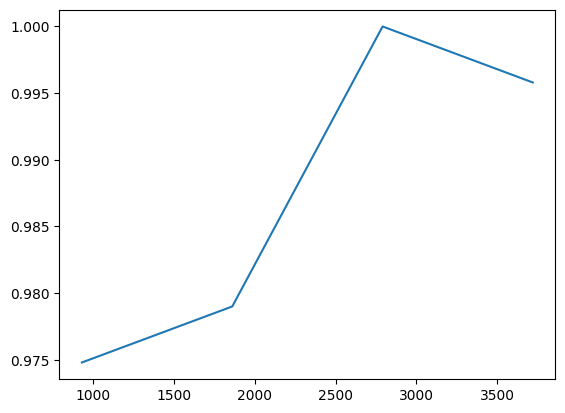

In [47]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

## 모델 사용하기
이제 모델을 호출하여 예측을 가져올 수 있습니다.

We can now call the model to get the predictions.

In [48]:
test = pd.read_json('sport2_prepared_valid.jsonl', lines=True)
test.head()

,prompt,completion
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
1,From: smorris@venus.lerc.nasa.gov (Ron Morris ...,hockey
2,From: golchowy@alchemy.chem.utoronto.ca (Geral...,hockey
3,From: krattige@hpcc01.corp.hp.com (Kim Krattig...,baseball
4,From: warped@cs.montana.edu (Doug Dolven)\nSub...,baseball


미세 조정할 때 사용한 프롬프트 다음에 동일한 구분 기호를 사용해야 합니다. 이 경우 `\n\n###\n\n`입니다. 우리는 분류에 관심이 있으므로 온도를 가능한 한 낮추고, 모델의 예측을 결정하기 위해 단 한 번의 토큰 완료만 요구합니다.

We need to use the same separator following the prompt which we used during fine-tuning. In this case it is `\n\n###\n\n`. Since we're concerned with classification, we want the temperature to be as low as possible, and we only require one token completion to determine the prediction of the model.

In [77]:
ft_model = 'ada:ft-inswave-systems-2023-03-05-07-26-34'
# ft_model = 'ada'
# ft_model = 'davinci'
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][4] + '\n\n###\n\n', max_tokens=1, temperature=1)
res['choices'][0]['text']

' baseball'

로그 확률을 얻으려면 완료 요청에 로그 프로브 파라미터를 지정하면 됩니다.

To get the log probabilities, we can specify logprobs parameter on the completion request

In [79]:
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][4] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['logprobs']['top_logprobs'][0]

<OpenAIObject at 0x13dd5acf0> JSON: {
  " baseball": -9.258174e-05,
  " hockey": -10.535937
}

모델이 야구보다 하키를 훨씬 더 많이 예측하는 것을 볼 수 있으며, 이는 올바른 예측입니다. log_probs를 요청하면 각 클래스에 대한 예측(로그) 확률을 확인할 수 있습니다.

We can see that the model predicts hockey as a lot more likely than baseball, which is the correct prediction. By requesting log_probs, we can see the prediction (log) probability for each class.

### 일반화
흥미롭게도 미세 조정된 분류기는 매우 다재다능합니다. 다양한 메일링 리스트에 대한 이메일에 대해 학습되었음에도 불구하고 트윗도 성공적으로 예측합니다.

Interestingly, our fine-tuned classifier is quite versatile. Despite being trained on emails to different mailing lists, it also successfully predicts tweets.

In [81]:
sample_hockey_tweet = """Thank you to the 
@Canes
 and all you amazing Caniacs that have been so supportive! You guys are some of the best fans in the NHL without a doubt! Really excited to start this new chapter in my career with the 
@DetroitRedWings
 !!"""
res = openai.Completion.create(model=ft_model, prompt=sample_hockey_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' hockey'

In [80]:
sample_baseball_tweet="""BREAKING: The Tampa Bay Rays are finalizing a deal to acquire slugger Nelson Cruz from the Minnesota Twins, sources tell ESPN."""
res = openai.Completion.create(model=ft_model, prompt=sample_baseball_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' baseball'